# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [14]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [15]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [16]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/LOG4J2.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)

graph_df['Bug'] = graph_df.Bug.astype('int')

x = graph_df["Name"]
y = graph_df["Bug"]

In [17]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Ralph Goers,log4j2-api/src/main/java/org/apache/logging/lo...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,0.138454,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
1,Ralph Goers,log4j2-api/src/main/java/org/apache/logging/lo...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,0.138454,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
2,Ralph Goers,log4j2-api/src/main/java/org/apache/logging/lo...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,0.138454,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
3,Ralph Goers,log4j2-api/src/main/java/org/apache/logging/lo...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,0.138454,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
4,Ralph Goers,log4j2-api/src/main/java/org/apache/logging/lo...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,0.138454,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56732,Curtis William Arnold,log4j2-core/src/main/java/org/apache/logging/l...,0,0.471688,0.000000,0.538462,0.577640,58.0,161,0.198336,...,0.649971,0.310094,-0.157107,-0.467964,-0.095001,0.036615,0.070047,0.278619,-0.075933,0.068524
56733,Curtis William Arnold,log4j2-core/src/main/java/org/apache/logging/l...,0,0.471688,0.000000,0.538462,0.577640,58.0,161,0.198336,...,0.649971,0.310094,-0.157107,-0.467964,-0.095001,0.036615,0.070047,0.278619,-0.075933,0.068524
56734,Curtis William Arnold,log4j2-core/log4j2-core.iml,0,0.471688,0.000000,0.538462,0.577640,58.0,161,0.198336,...,0.649971,0.310094,-0.157107,-0.467964,-0.095001,0.036615,0.070047,0.278619,-0.075933,0.068524
56735,Curtis William Arnold,log4j2-api/src/main/java/org/apache/logging/lo...,0,0.471688,0.000000,0.538462,0.577640,58.0,161,0.198336,...,0.649971,0.310094,-0.157107,-0.467964,-0.095001,0.036615,0.070047,0.278619,-0.075933,0.068524


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [18]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    50453
1     6284
Name: Bug, dtype: int64


Creating models...

In [19]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [20]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [21]:
print(train['Bug'].value_counts())
train

0    35363
1     4352
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,15793,Matt Sicker,log4j-core/src/main/java/org/apache/logging/lo...,0,9.875962,4121.988663,0.930636,0.962733,34191.0,118,...,0.182441,0.154127,-0.147064,-0.275747,0.149868,0.091081,-0.190946,0.176933,0.250319,0.370110
1,14253,Matt Sicker,{log4j-streams/src/test/java/org/apache/loggin...,0,9.875962,4121.988663,0.930636,0.962733,34191.0,118,...,0.182441,0.154127,-0.147064,-0.275747,0.149868,0.091081,-0.190946,0.176933,0.250319,0.370110
2,52000,Gary D. Gregory,{taglib => log4j-taglib}/src/main/java/org/apa...,0,6.666541,591.039220,0.766667,0.849896,26711.0,161,...,0.592938,-0.518472,-0.025450,-0.307645,0.057532,0.185763,-0.086523,0.057477,0.074957,-0.051745
3,53651,Gary D. Gregory,log4j-core/src/main/java/org/apache/logging/lo...,0,6.666541,591.039220,0.766667,0.849896,26711.0,161,...,0.592938,-0.518472,-0.025450,-0.307645,0.057532,0.185763,-0.086523,0.057477,0.074957,-0.051745
4,32525,rpopma,log4j-core/pom.xml,0,9.710788,2042.538767,0.851852,0.915114,74396.0,118,...,0.322404,-0.133371,0.134308,0.202661,0.242238,0.110687,0.159813,-0.272389,0.161017,0.068676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39710,56438,nickwilliams,flume-ng/src/test/resources/persistent.xml,1,3.080425,78.780381,0.649194,0.733954,6824.0,69,...,0.073298,0.054245,0.076881,-0.285032,0.523242,0.384272,0.357067,0.221500,0.525472,-0.437236
39711,35814,rpopma,log4j-nosql/pom.xml,0,9.710788,2042.538767,0.851852,0.915114,74396.0,118,...,0.322404,-0.133371,0.134308,0.202661,0.242238,0.110687,0.159813,-0.272389,0.161017,0.068676
39712,20463,Gary Gregory,log4j-streams/src/main/java/org/apache/logging...,0,9.315375,3561.158418,0.920000,0.958592,66387.0,118,...,-0.032423,0.231526,-0.213324,-0.011258,0.307800,0.137271,0.406111,-0.060702,0.136353,0.489408
39713,18638,Matt Sicker,log4j-nosql/src/site/markdown/index.md.vm,1,9.875962,4121.988663,0.930636,0.962733,34191.0,118,...,0.182441,0.154127,-0.147064,-0.275747,0.149868,0.091081,-0.190946,0.176933,0.250319,0.370110


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [22]:
print(test['Bug'].value_counts())
test

0    15090
1     1932
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,5441,Ralph Goers,log4j-samples/configuration/src/main/java/org/...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
1,2161,Ralph Goers,{log4j2-core => core}/src/main/java/org/apache...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
2,12222,Ralph Goers,log4j-async/src/test/resources/perf-log4j12-as...,1,11.598309,5612.154828,0.936047,0.967909,64238.0,69,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
3,2310,Ralph Goers,{log4j2-core => core}/src/main/java/org/apache...,0,11.598309,5612.154828,0.936047,0.967909,64238.0,69,...,-0.179275,-0.162226,-0.197651,-0.184293,0.068709,-0.089152,-0.199137,-0.051908,-0.038152,0.229349
4,25422,Gary Gregory,src/site/xdoc/manual/appenders.xml,0,9.315375,3561.158418,0.920000,0.958592,66387.0,118,...,-0.032423,0.231526,-0.213324,-0.011258,0.307800,0.137271,0.406111,-0.060702,0.136353,0.489408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17017,27658,rgoers,log4j-nosql/pom.xml,0,2.561481,221.215679,0.668050,0.755694,12625.0,69,...,-0.011389,-0.384513,-0.084086,-0.244585,0.169200,0.318589,0.135548,-0.227261,0.027469,-0.170751
17018,29171,rpopma,core/src/test/java/org/apache/logging/log4j/co...,0,9.710788,2042.538767,0.851852,0.915114,74396.0,118,...,0.322404,-0.133371,0.134308,0.202661,0.242238,0.110687,0.159813,-0.272389,0.161017,0.068676
17019,37745,ggregory,log4j-jul/src/main/java/org/apache/logging/log...,0,7.164799,882.936536,0.813131,0.887164,28371.0,69,...,-0.089143,0.145868,-0.129104,0.269169,0.152138,-0.205338,0.226330,-0.082303,0.121166,0.363529
17020,52925,Gary D. Gregory,log4j-core/src/main/java/org/apache/logging/lo...,0,6.666541,591.039220,0.766667,0.849896,26711.0,161,...,0.592938,-0.518472,-0.025450,-0.307645,0.057532,0.185763,-0.086523,0.057477,0.074957,-0.051745


In [23]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.8864998237574903
Logistic regression training score for model 2: 0.8864998237574903
Random Forrest Classification training score for model 1: 0.8866760662671836
Random Forrest Classification training score for model 2: 0.8866760662671836
XGB Classifier training score for model 1: 0.8866760662671836
XGB Classifier training score for model 2: 0.8866760662671836


Compare model scores for Logistic Regression

In [24]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5389213374000305
Average Precision-Recall Score: 0.12673983325152924
PRC-AUC for model 1: 0.11048184891147653
Accuracy: 0.886
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15090
           1       0.00      0.00      0.00      1932

    accuracy                           0.89     17022
   macro avg       0.44      0.50      0.47     17022
weighted avg       0.79      0.89      0.83     17022


Scores for model 2
------------------
Roc_Auc Score: 0.7542677166812787
Average Precision-Recall Score: 0.22863827452272487
PRC-AUC for model 2: 0.256094497018164
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15090
           1       0.00      0.00      0.00      1932

    accuracy    

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.092815, F1-Score=0.238 for model 1
Best Threshold=0.188345, F1-Score=0.334 for model 2


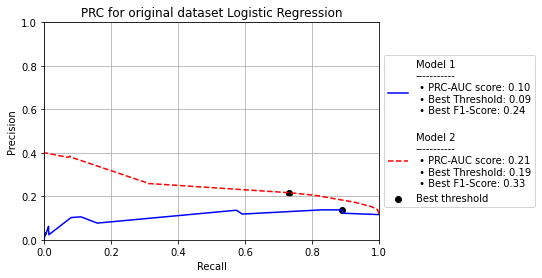

In [25]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.188481, F1-Score=0.335 for model 1
Best Threshold=0.187813, F1-Score=0.335 for model 2


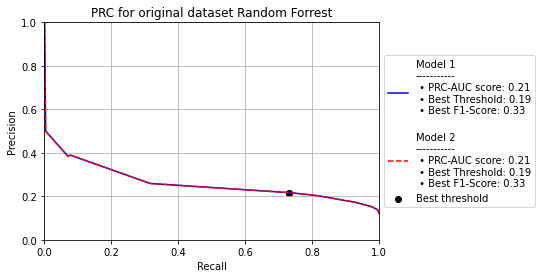

In [26]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.188662, F1-Score=0.335 for model 1
Best Threshold=0.188663, F1-Score=0.335 for model 2


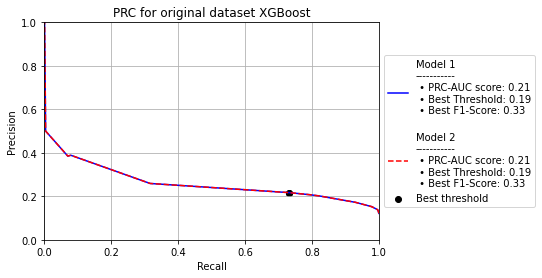

In [27]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

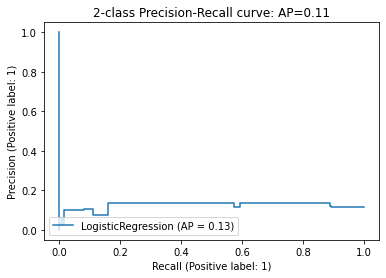

In [28]:
simple_threshold_plot(lr_model1, x1_test, y_test)

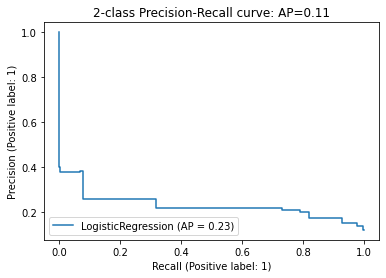

In [29]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [30]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf_model1.score(x1_test, y_test)
results_data[4][2] = rf_model2.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb_model1.score(x1_test, y_test)
results_data[5][2] = xgb_model2.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5389213374000305
Average Precision-Recall Score: 0.12673983325152924
PRC-AUC for model 1: 0.09726146281459852
Accuracy: 0.355
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.29      0.44     15090
           1       0.14      0.89      0.24      1932

    accuracy                           0.35     17022
   macro avg       0.55      0.59      0.34     17022
weighted avg       0.86      0.35      0.42     17022


Scores for model 2
------------------
Roc_Auc Score: 0.7542677166812787
Average Precision-Recall Score: 0.22863827452272487
PRC-AUC for model 2: 0.2062504959887285
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     15090
           1       0.22      0.73      0.33      1932

    accuracy                           0.67     17022
   macro avg       0.58      0.70      0.56     17022
weight

### Cross Validation

In [31]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [32]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.88922963 0.88927665 0.88922377]

Cross validation results for model 2
------------------------------------
[0.15227621 0.88943528 0.40323604]


#### Model 1 Cross Validation

#### Leave One Out

In [33]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [34]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, x1, y)
results_data[6][0] = "Original_Logistic_Regression_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, x1, y)
results_data[8][0] = "Original_Random_Forrest_rkf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, x1, y)
results_data[9][0] = "Original_XGB_Classifier_rkf"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     2     3 ... 56733 56735 56736] | TEST: [    1    21    31 ... 56725 56729 56734]

Model Score: 0.8806627886479816
Average Precision-Recall Score: 0.11933721135201833
PRC-AUC Score: 0.1032604701758898
Classification Report:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4996
           1       0.00      0.00      0.00       677

    accuracy                           0.88      5673
   macro avg       0.44      0.50      0.47      5673
weighted avg       0.78      0.88      0.82      5673

Accuracy: 0.881
---------------------
With best threshold
TRAIN: [    0     2     3 ... 56733 56735 56736] | TEST: [    1    21    31 ... 56725 56729 56734]

Model Score: 0.8806627886479816
Average Precision-Recall Score: 0.11933721135201833
PRC-AUC Score: 0.5191420986199903
Classification Report:

          

#### Stratified KFold

In [35]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, x1, y)
results_data[10][0] = "Original_Logistic_Regression_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, x1, y, lr_best_threshold1)
results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, x1, y)
results_data[12][0] = "Original_Random_Forrest_skf"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, x1, y)
results_data[13][0] = "Original_XGB_Classifier_skf"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 56734 56735 56736] | TEST: [12971 12972 12973 ... 22936 22937 22938]

Model Score: 0.8891434614028904

Average Precision-Recall Score: 0.11085653859710962
PRC-AUC Score: 0.06580874659970705
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5045
           1       0.00      0.00      0.00       629

    accuracy                           0.89      5674
   macro avg       0.44      0.50      0.47      5674
weighted avg       0.79      0.89      0.84      5674

Accuracy: 0.889
---------------------
With best threshold
TRAIN: [    0     1     2 ... 56734 56735 56736] | TEST: [12971 12972 12973 ... 22936 22937 22938]

Model Score: 0.8891434614028904

Average Precision-Recall Score: 0.11085653859710962
PRC-AUC Score: 0.5554282692985548
Classification Report:

       

#### Time Series Split

In [36]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, x1, y)
results_data[14][0] = "Original_Logistic_Regression_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, x1, y, lr_best_threshold1)
results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, x1, y)
results_data[16][0] = "Original_Random_Forrest_tss"
results_data[16][1] = model_score
results_data[16][3] = acc
results_data[16][5] = prc_val
results_data[16][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, x1, y)
results_data[17][0] = "Original_XGB_Classifier_tss"
results_data[17][1] = model_score
results_data[17][3] = acc
results_data[17][5] = prc_val
results_data[17][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 47278 47279 47280] | TEST: [47281 47282 47283 ... 56734 56735 56736]

Model Score: 0.7776015228426396

Average Precision-Recall Score: 0.2223984771573604
PRC-AUC Score: 0.22953428261799957
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7353
           1       0.00      0.00      0.00      2103

    accuracy                           0.78      9456
   macro avg       0.39      0.50      0.44      9456
weighted avg       0.60      0.78      0.68      9456

Accuracy: 0.778
---------------------
With best threshold
TRAIN: [    0     1     2 ... 47278 47279 47280] | TEST: [47281 47282 47283 ... 56734 56735 56736]

Model Score: 0.7776015228426396

Average Precision-Recall Score: 0.2223984771573604
PRC-AUC Score: 0.3275408587002028
Classification Report:

         

#### Model 2 Cross Validation

#### Leave One Out

In [37]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [38]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, x2, y, lr_best_threshold2)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, x2, y)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     2     3 ... 56733 56735 56736] | TEST: [    1    21    31 ... 56725 56729 56734]

Model Score: 0.8806627886479816
Average Precision-Recall Score: 0.11933721135201833
PRC-AUC Score: 0.20571684105417842
Classification Report:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4996
           1       0.00      0.00      0.00       677

    accuracy                           0.88      5673
   macro avg       0.44      0.50      0.47      5673
weighted avg       0.78      0.88      0.82      5673

Accuracy: 0.881
---------------------
With best threshold
TRAIN: [    0     2     3 ... 56733 56735 56736] | TEST: [    1    21    31 ... 56725 56729 56734]

Model Score: 0.8806627886479816
Average Precision-Recall Score: 0.11933721135201833
PRC-AUC Score: 0.20320020668235508
Classification Report:

        

#### Stratified KFold

In [39]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, x2, y, lr_best_threshold2)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, x2, y)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 56734 56735 56736] | TEST: [12971 12972 12973 ... 22936 22937 22938]

Model Score: 0.8891434614028904

Average Precision-Recall Score: 0.11085653859710962
PRC-AUC Score: 0.2885321100917431
Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5045
           1       0.00      0.00      0.00       629

    accuracy                           0.89      5674
   macro avg       0.44      0.50      0.47      5674
weighted avg       0.79      0.89      0.84      5674

Accuracy: 0.889
---------------------
With best threshold
TRAIN: [    0     1     2 ... 56734 56735 56736] | TEST: [12971 12972 12973 ... 22936 22937 22938]

Model Score: 0.8891434614028904

Average Precision-Recall Score: 0.11085653859710962
PRC-AUC Score: 0.05542826929855481
Classification Report:

       

#### Time Series Split

In [40]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, x2, y, lr_best_threshold2)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, x2, y)
results_data[16][2] = model_score
results_data[16][4] = acc
results_data[16][6] = prc_val
results_data[16][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, x2, y)
results_data[17][2] = model_score
results_data[17][4] = acc
results_data[17][6] = prc_val
results_data[17][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 47278 47279 47280] | TEST: [47281 47282 47283 ... 56734 56735 56736]

Model Score: 0.7776015228426396

Average Precision-Recall Score: 0.2223984771573604
PRC-AUC Score: 0.19121893801273473
Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      7353
           1       0.00      0.00      0.00      2103

    accuracy                           0.78      9456
   macro avg       0.39      0.50      0.44      9456
weighted avg       0.60      0.78      0.68      9456

Accuracy: 0.778
---------------------
With best threshold
TRAIN: [    0     1     2 ... 47278 47279 47280] | TEST: [47281 47282 47283 ... 56734 56735 56736]

Model Score: 0.7776015228426396

Average Precision-Recall Score: 0.2223984771573604
PRC-AUC Score: 0.6111992385786802
Classification Report:

         

Best Threshold=0.093438, F1-Score=0.252 for model 1
Best Threshold=0.187920, F1-Score=0.352 for model 2


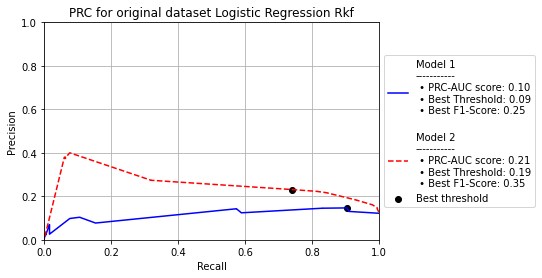

Best Threshold=0.187509, F1-Score=0.353 for model 1
Best Threshold=0.188156, F1-Score=0.353 for model 2


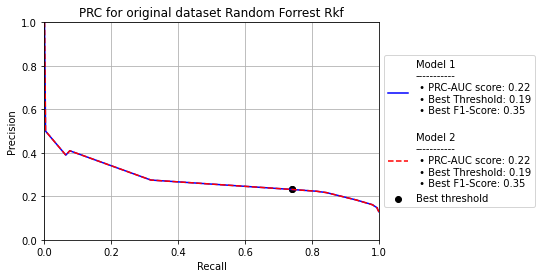

Best Threshold=0.188073, F1-Score=0.353 for model 1
Best Threshold=0.188076, F1-Score=0.353 for model 2


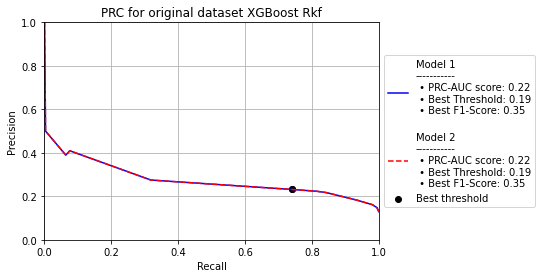

Best Threshold=0.116871, F1-Score=0.233 for model 1
Best Threshold=0.150887, F1-Score=0.732 for model 2


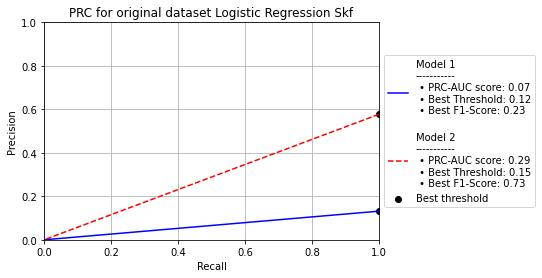

Best Threshold=0.151141, F1-Score=0.602 for model 1
Best Threshold=0.150900, F1-Score=1.000 for model 2


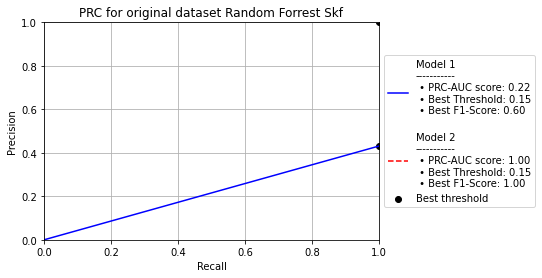

Best Threshold=0.150942, F1-Score=1.000 for model 1
Best Threshold=0.150945, F1-Score=1.000 for model 2


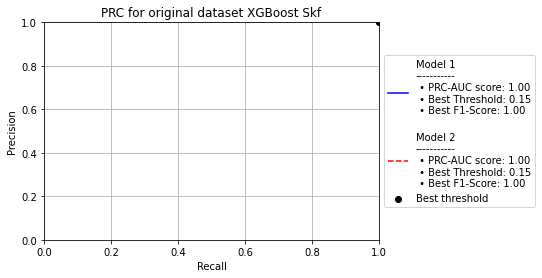

Best Threshold=0.062124, F1-Score=0.364 for model 1
Best Threshold=0.000567, F1-Score=0.365 for model 2


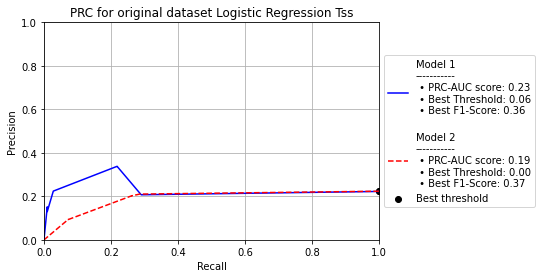

Best Threshold=0.000000, F1-Score=0.364 for model 1
Best Threshold=0.000706, F1-Score=0.364 for model 2


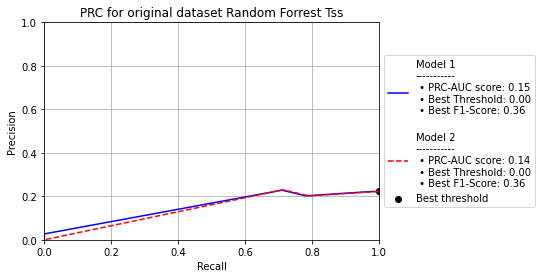

Best Threshold=0.000066, F1-Score=0.364 for model 1
Best Threshold=0.000105, F1-Score=0.364 for model 2


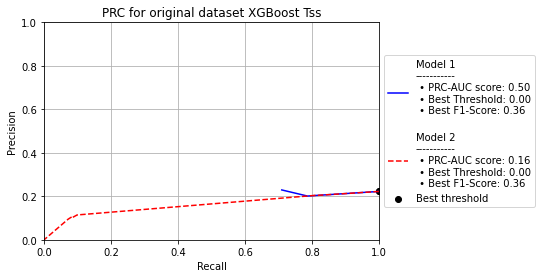

In [41]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

### Rebalancing data

#### Undersampling

In [42]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

0    1900
1    1900
Name: Bug, dtype: int64


In [43]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr_model1.score(x1_test, y_test)
results_data[18][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf_model1.score(x1_test, y_test)
results_data[19][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb_model1.score(x1_test, y_test)
results_data[20][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.5789473684210527
Logistic regression training score for model 2: 0.7149122807017544
Random Forrest Classification training score for model 1: 0.7070175438596491
Random Forrest Classification training score for model 2: 0.7087719298245614
XGB Classifier training score for model 1: 0.7131578947368421
XGB Classifier training score for model 2: 0.7131578947368421


In [44]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.6334612340675821
Average Precision-Recall Score: 0.593624045547973
PRC-AUC for model 1: 0.4593593133929808
Accuracy: 0.579
Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       583
           1       0.58      0.51      0.54       557

    accuracy                           0.58      1140
   macro avg       0.58      0.58      0.58      1140
weighted avg       0.58      0.58      0.58      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7654658779112559
Average Precision-Recall Score: 0.6934125077077753
PRC-AUC for model 2: 0.7217636937785257
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.63      0.69       583
           1       0.67      0.81      0.73       557

    accuracy       

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.489416, F1-Score=0.678 for model 1
Best Threshold=0.378331, F1-Score=0.740 for model 2


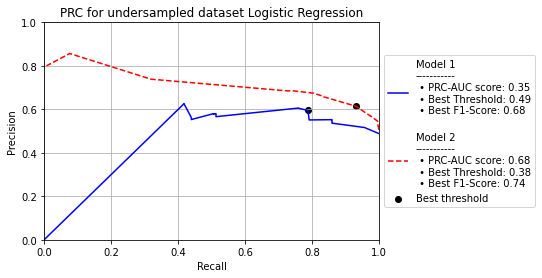

In [45]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.379209, F1-Score=0.740 for model 1
Best Threshold=0.380135, F1-Score=0.741 for model 2


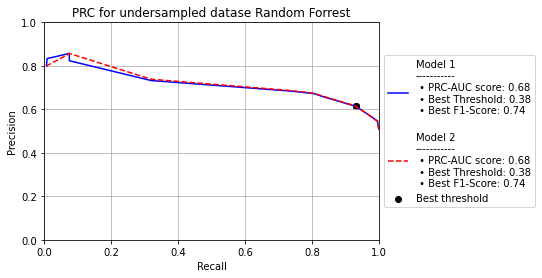

In [46]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.379293, F1-Score=0.740 for model 1
Best Threshold=0.379312, F1-Score=0.740 for model 2


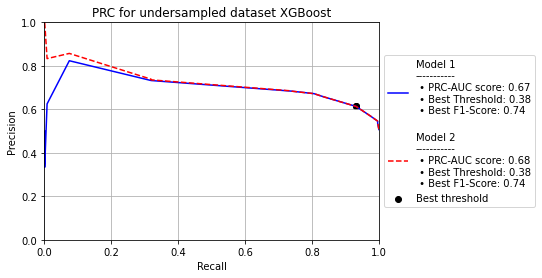

In [47]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

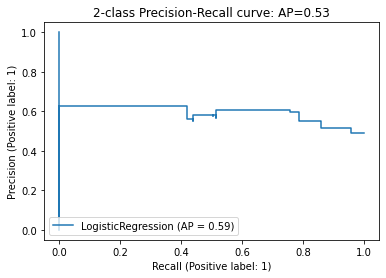

In [48]:
simple_threshold_plot(lr_model1, x1_test, y_test)

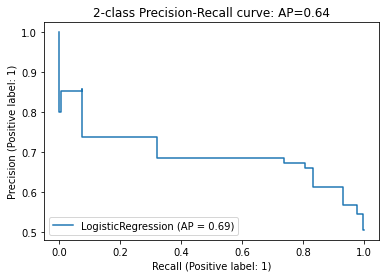

In [49]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [50]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr_model1.score(x1_test, y_test)
results_data[21][2] = lr_model2.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf_model1.score(x1_test, y_test)
results_data[22][2] = rf_model2.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb_model1.score(x1_test, y_test)
results_data[23][2] = xgb_model2.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.6334612340675821
Average Precision-Recall Score: 0.593624045547973
PRC-AUC for model 1: 0.3469621680168166
Accuracy: 0.634
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.49      0.58       583
           1       0.59      0.79      0.68       557

    accuracy                           0.63      1140
   macro avg       0.65      0.64      0.63      1140
weighted avg       0.65      0.63      0.63      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7654658779112559
Average Precision-Recall Score: 0.6934125077077753
PRC-AUC for model 2: 0.6824002466994721
Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.44      0.59       583
           1       0.61      0.93      0.74       557

    accuracy                           0.68      1140
   macro avg       0.74      0.69      0.66      1140
weighted a

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [51]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_rkf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   1    2    3 ... 3796 3798 3799] | TEST: [   0   29   30   44   61   63   80   88  102  124  152  156  166  173
  175  178  192  194  203  217  218  221  239  247  254  257  274  278
  283  289  295  305  314  324  331  332  346  368  371  376  387  408
  411  416  423  430  433  436  442  449  468  479  495  500  506  534
  549  551  554  557  561  564  573  578  599  602  621  644  650  655
  670  691  700  705  712  720  721  727  755  787  802  805  809  810
  811  816  842  864  879  893  897  915  927  929  948  949  965  976
  978  985 1022 1023 1034 1047 1052 1056 1074 1078 1080 1110 1113 1114
 1116 1117 1123 1128 1146 1149 1164 1174 1187 1188 1226 1228 1231 1251
 1272 1293 1295 1313 1320 1351 1352 1356 1361 1362 1402 1406 1407 1411
 1412 1417 1422 1429 1454 1457 1487 1490 1498 1511 1513 1546 1554 1556
 1572 1582 1583 1588 1593 1602 1612 1620 1621 1

In [52]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_skf"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_skf"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_skf"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1482 1486 1488 1491 1492 1493 1495 1496 1497 1498 1499 1501 1506 1507
 1508 1509 1510 1512 1513 1514 1516 1518 1522 1524 1528 1529 1530 1533
 1536 1538 1539 1540 1543 1545 1547 1550 1551 1552 1555 1558 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589
 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603
 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645
 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673
 1674 1675 1676 1677 1678 1679 1680 1681 1682 1

In [53]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, usx1, usy)
results_data[32][0] = "Undersampled_Logistic_Regression_tss"
results_data[32][1] = model_score
results_data[32][3] = acc
results_data[32][5] = prc_val
results_data[32][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[33][1] = model_score
results_data[33][3] = acc
results_data[33][5] = prc_val
results_data[33][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, usx1, usy)
results_data[34][0] = "Undersampled_Random_Forrest_tss"
results_data[34][1] = model_score
results_data[34][3] = acc
results_data[34][5] = prc_val
results_data[34][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, usx1, usy)
results_data[35][0] = "Undersampled_XGB_Classifier_tss"
results_data[35][1] = model_score
results_data[35][3] = acc
results_data[35][5] = prc_val
results_data[35][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 2531 2532 2533] | TEST: [2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547
 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561
 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575
 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589
 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603
 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617
 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631
 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645
 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659
 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673
 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687
 2688 2689 2690 2691 2692 2693 2694 2695 2696 2

TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 

##### Cross Validation After Undersampling Rebalance for model 2

In [54]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [   3    6   15   28   45   51   57   59   78  110  117  122  129  130
  143  161  163  181  184  187  189  200  210  216  242  243  259  262
  266  279  290  293  302  315  316  320  325  329  331  333  335  340
  347  357  358  371  380  390  395  409  410  420  421  426  434  438
  439  443  467  475  479  505  506  521  522  523  526  527  530  537
  553  558  565  575  577  587  599  606  610  612  626  638  640  651
  655  662  665  693  705  710  728  730  746  751  767  781  784  787
  794  797  805  817  836  845  846  847  854  864  876  880  906  907
  911  916  920  923  926  940  962  986 1004 1043 1049 1065 1077 1100
 1101 1109 1110 1119 1125 1130 1131 1133 1161 1165 1173 1179 1183 1192
 1223 1227 1238 1243 1248 1298 1301 1329 1333 1339 1343 1345 1347 1360
 1367 1371 1379 1384 1397 1409 1423 1431 1433 1

In [55]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1482 1486 1488 1491 1492 1493 1495 1496 1497 1498 1499 1501 1506 1507
 1508 1509 1510 1512 1513 1514 1516 1518 1522 1524 1528 1529 1530 1533
 1536 1538 1539 1540 1543 1545 1547 1550 1551 1552 1555 1558 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589
 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603
 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645
 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673
 1674 1675 1676 1677 1678 1679 1680 1681 1682 1

In [56]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, usx2, usy)
results_data[32][2] = model_score
results_data[32][4] = acc
results_data[32][6] = prc_val
results_data[32][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
results_data[33][2] = model_score
results_data[33][4] = acc
results_data[33][6] = prc_val
results_data[33][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, usx2, usy)
results_data[34][2] = model_score
results_data[34][4] = acc
results_data[34][6] = prc_val
results_data[34][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, usx2, usy)
results_data[35][2] = model_score
results_data[35][4] = acc
results_data[35][6] = prc_val
results_data[35][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1

TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 

Best Threshold=0.468988, F1-Score=0.721 for model 1
Best Threshold=0.431507, F1-Score=0.703 for model 2


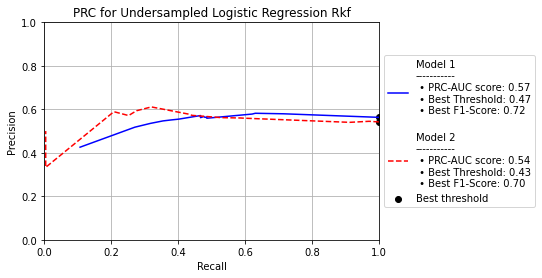

Best Threshold=0.436235, F1-Score=0.703 for model 1
Best Threshold=0.431650, F1-Score=0.703 for model 2


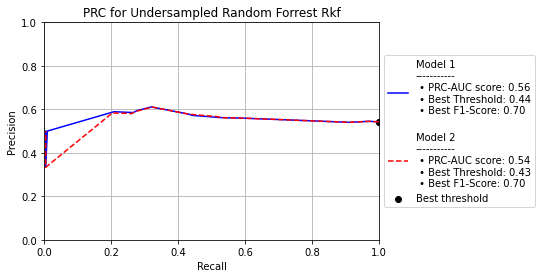

Best Threshold=0.432815, F1-Score=0.703 for model 1
Best Threshold=0.432921, F1-Score=0.703 for model 2


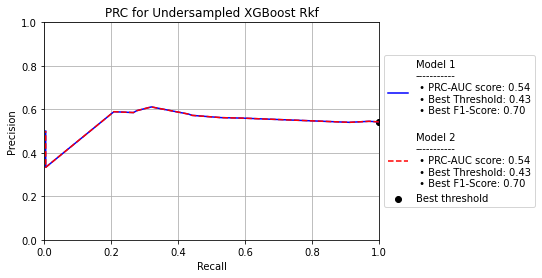

Best Threshold=0.483589, F1-Score=0.667 for model 1
Best Threshold=0.441273, F1-Score=0.667 for model 2


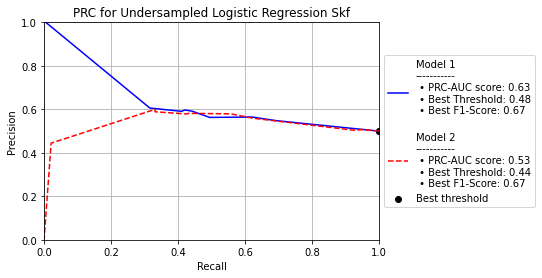

Best Threshold=0.441048, F1-Score=0.667 for model 1
Best Threshold=0.447625, F1-Score=0.667 for model 2


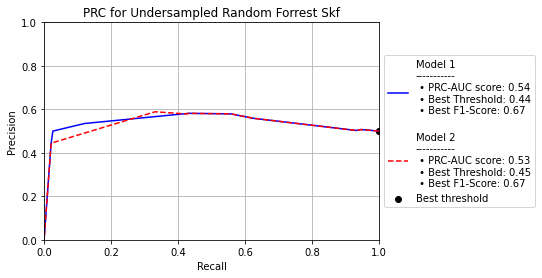

Best Threshold=0.442598, F1-Score=0.667 for model 1
Best Threshold=0.442675, F1-Score=0.667 for model 2


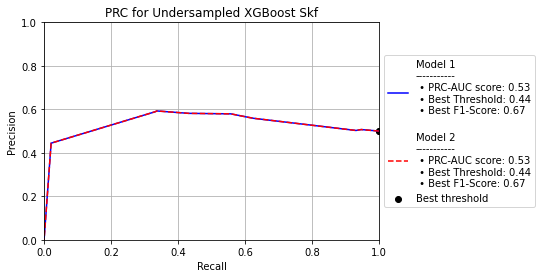

Best Threshold=0.468601, F1-Score=0.684 for model 1
Best Threshold=0.192878, F1-Score=0.672 for model 2


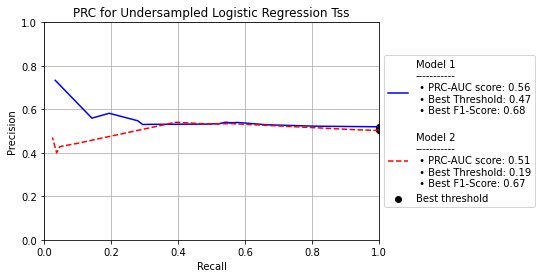

Best Threshold=0.142236, F1-Score=0.672 for model 1
Best Threshold=0.146156, F1-Score=0.672 for model 2


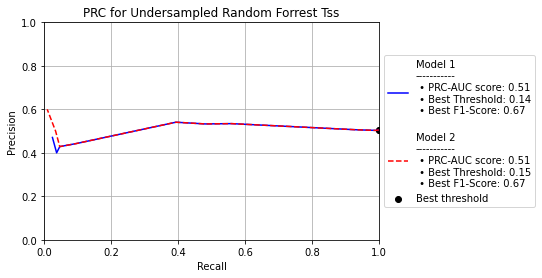

Best Threshold=0.136969, F1-Score=0.672 for model 1
Best Threshold=0.042853, F1-Score=0.672 for model 2


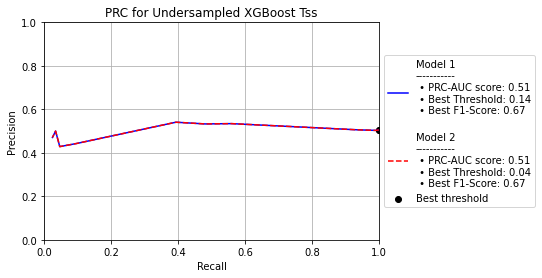

In [57]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Undersampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Undersampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Undersampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Undersampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Undersampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Undersampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Undersampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Undersampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Undersampled XGBoost Tss")

#### Oversampling

In [58]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [59]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(100906, 5)
x2 After SMOTE:
(100906, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [60]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr_model1.score(x1_test, y1_test)
results_data[36][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf_model1.score(x1_test, y1_test)
results_data[37][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb_model1.score(x1_test, y1_test)
results_data[38][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5291358350951374
Logistic regression training score for model 2: 0.7040499471458774
Random Forrest Classification training score for model 1: 0.7040829809725159
Random Forrest Classification training score for model 2: 0.7040829809725159
XGB Classifier training score for model 1: 0.7040169133192389
XGB Classifier training score for model 2: 0.7040829809725159


In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.511911998876144
Average Precision-Recall Score: 0.5286157269202303
PRC-AUC for model 1: 0.45722522176865465
Accuracy: 0.529
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.62      0.57     15229
           1       0.53      0.43      0.48     15043

    accuracy                           0.53     30272
   macro avg       0.53      0.53      0.52     30272
weighted avg       0.53      0.53      0.52     30272


Scores for model 2
------------------
Roc_Auc Score: 0.7539997069359429
Average Precision-Recall Score: 0.6882008553944375
PRC-AUC for model 2: 0.7198262532410814
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.62      0.68     15229
           1       0.67      0.79      0.73     15043

    accuracy      

In [62]:
y1_test.value_counts()

0    15229
1    15043
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.434175, F1-Score=0.664 for model 1
Best Threshold=0.408974, F1-Score=0.739 for model 2


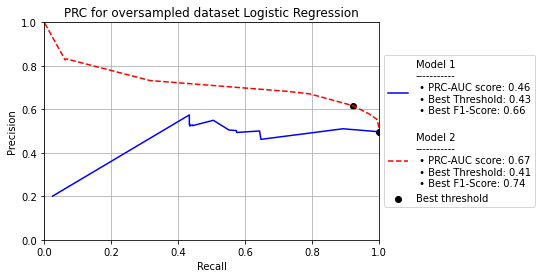

In [63]:
lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.366667, F1-Score=0.739 for model 1
Best Threshold=0.347589, F1-Score=0.739 for model 2


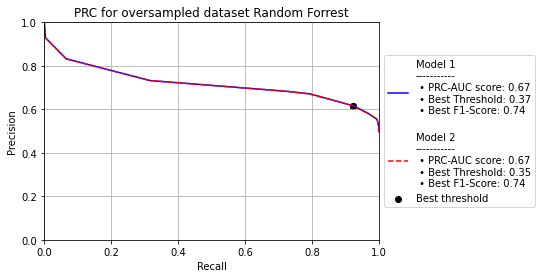

In [64]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.409160, F1-Score=0.739 for model 1
Best Threshold=0.409157, F1-Score=0.739 for model 2


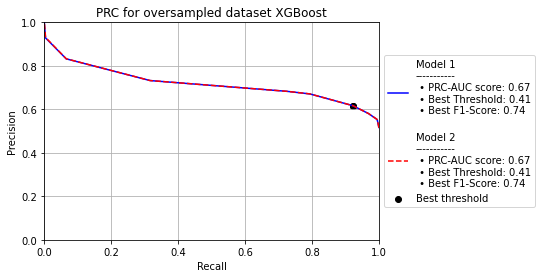

In [65]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

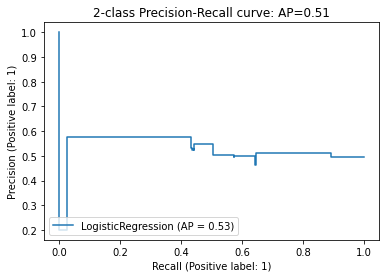

In [66]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

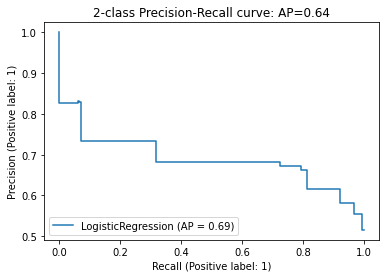

In [67]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [68]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr_model1.score(x1_test, y1_test)
results_data[39][2] = lr_model2.score(x2_test, y2_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf_model1.score(x1_test, y1_test)
results_data[40][2] = rf_model2.score(x2_test, y2_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb_model1.score(x1_test, y1_test)
results_data[41][2] = xgb_model2.score(x2_test, y2_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.511911998876144
Average Precision-Recall Score: 0.5286157269202303
PRC-AUC for model 1: 0.45722522176865465
Accuracy: 0.497
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15229
           1       0.50      1.00      0.66     15043

    accuracy                           0.50     30272
   macro avg       0.25      0.50      0.33     30272
weighted avg       0.25      0.50      0.33     30272


Scores for model 2
------------------
Roc_Auc Score: 0.7539997069359429
Average Precision-Recall Score: 0.6882008553944375
PRC-AUC for model 2: 0.6745723352260834
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.43      0.57     15229
           1       0.62      0.92      0.74     15043

    accuracy                           0.68     30272
   macro avg       0.73      0.68      0.66     30272
weighted 

##### Cross Validation After Oversampling Rebalance for model 1

In [69]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Random_Forrest_rkf"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, osx1, osy1)
results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.5278493557978197
Average Precision-Recall Score: 0.5276150594314164
PRC-AUC Score: 0.46780922002987674
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.61      0.56      4927
           1       0.55      0.45      0.49      5163

    accuracy                           0.53     10090
   macro avg       0.53      0.53      0.53     10090
weighted avg       0.53      0.53      0.52     10090

Accuracy: 0.528
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.5278493557978197
Average Precision-Recall Score: 0.5276150594314164
PRC-AUC Score: 0.7347560359477308
Classificat

In [70]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Logistic_Regression_skf"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, osx1, osy1)
results_data[48][0] = "Oversampled_Random_Forrest_skf"
results_data[48][1] = model_score
results_data[48][3] = acc
results_data[48][5] = prc_val
results_data[48][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, osx1, osy1)
results_data[49][0] = "Oversampled_XGB_Classifier_skf"
results_data[49][1] = model_score
results_data[49][3] = acc
results_data[49][5] = prc_val
results_data[49][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 49740  49741  49742 ... 100903 100904 100905]

Model Score: 0.720812685827552

Average Precision-Recall Score: 0.6741661490340178
PRC-AUC Score: 0.5786923485112986
Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      5045
           1       0.79      0.60      0.68      5045

    accuracy                           0.72     10090
   macro avg       0.73      0.72      0.72     10090
weighted avg       0.73      0.72      0.72     10090

Accuracy: 0.721
---------------------
With best threshold
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 49740  49741  49742 ... 100903 100904 100905]

Model Score: 0.720812685827552

Average Precision-Recall Score: 0.6741661490340178
PRC-AUC Score: 0.7105706961103855
Classification Report:



In [71]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, osx1, osy1)
results_data[50][0] = "Oversampled_Logistic_Regression_tss"
results_data[50][1] = model_score
results_data[50][3] = acc
results_data[50][5] = prc_val
results_data[50][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[51][1] = model_score
results_data[51][3] = acc
results_data[51][5] = prc_val
results_data[51][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, osx1, osy1)
results_data[52][0] = "Oversampled_Random_Forrest_tss"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, osx1, osy1)
results_data[53][0] = "Oversampled_XGB_Classifier_tss"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 67269 67270 67271] | TEST: [67272 67273 67274 ... 84086 84087 84088]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16817.0

    accuracy                           0.00   16817.0
   macro avg       0.00      0.00      0.00   16817.0
weighted avg       0.00      0.00      0.00   16817.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 67269 67270 67271] | TEST: [67272 67273 67274 ... 84086 84087 84088]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0

##### Cross Validation After Oversampling Rebalance for model 2

In [72]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, osx2, osy2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.7062438057482656
Average Precision-Recall Score: 0.6483976656909599
PRC-AUC Score: 0.6707443954432438
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.62      0.67      4927
           1       0.69      0.79      0.73      5163

    accuracy                           0.71     10090
   macro avg       0.71      0.70      0.70     10090
weighted avg       0.71      0.71      0.70     10090

Accuracy: 0.706
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.7062438057482656
Average Precision-Recall Score: 0.6483976656909599
PRC-AUC Score: 0.6814321988836857
Classificati

In [73]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, osx2, osy2)
results_data[48][2] = model_score
results_data[48][4] = acc
results_data[48][6] = prc_val
results_data[48][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model1, osx1, osy1)
results_data[49][2] = model_score
results_data[49][4] = acc
results_data[49][6] = prc_val
results_data[49][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100903 100904 100905] | TEST: [17738 17739 17740 ... 70631 70632 70633]

Model Score: 0.8958477851550887

Average Precision-Recall Score: 0.8957693770800554
PRC-AUC Score: 0.9168137889089372
Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5045
           1       1.00      0.79      0.88      5046

    accuracy                           0.90     10091
   macro avg       0.91      0.90      0.89     10091
weighted avg       0.91      0.90      0.89     10091

Accuracy: 0.896
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100903 100904 100905] | TEST: [17738 17739 17740 ... 70631 70632 70633]

Model Score: 0.8958477851550887

Average Precision-Recall Score: 0.8957693770800554
PRC-AUC Score: 0.816191066460409
Classification Report:


In [74]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, osx2, osy2)
results_data[50][2] = model_score
results_data[50][4] = acc
results_data[50][6] = prc_val
results_data[50][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[51][2] = model_score
results_data[51][4] = acc
results_data[51][6] = prc_val
results_data[51][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, osx2, osy2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, osx2, osy2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 67269 67270 67271] | TEST: [67272 67273 67274 ... 84086 84087 84088]

Model Score: 0.07189153832431468

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.07      0.13     16817

    accuracy                           0.07     16817
   macro avg       0.50      0.04      0.07     16817
weighted avg       1.00      0.07      0.13     16817

Accuracy: 0.072
---------------------
With best threshold
TRAIN: [    0     1     2 ... 67269 67270 67271] | TEST: [67272 67273 67274 ... 84086 84087 84088]

Model Score: 0.07189153832431468

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0 

Best Threshold=0.430360, F1-Score=0.677 for model 1
Best Threshold=0.404779, F1-Score=0.752 for model 2


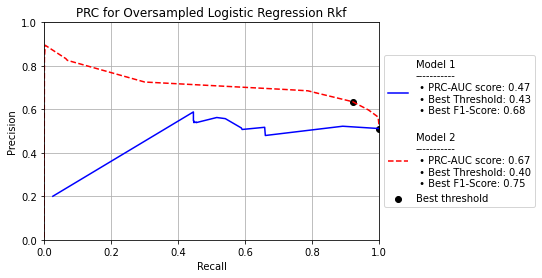

Best Threshold=0.405701, F1-Score=0.752 for model 1
Best Threshold=0.404671, F1-Score=0.752 for model 2


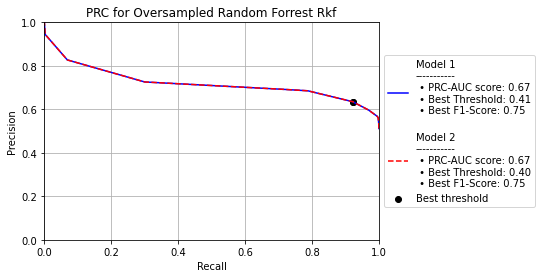

Best Threshold=0.404967, F1-Score=0.752 for model 1
Best Threshold=0.404974, F1-Score=0.752 for model 2


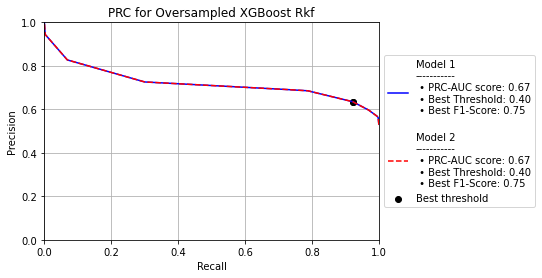

Best Threshold=0.500651, F1-Score=0.685 for model 1
Best Threshold=0.383564, F1-Score=0.958 for model 2


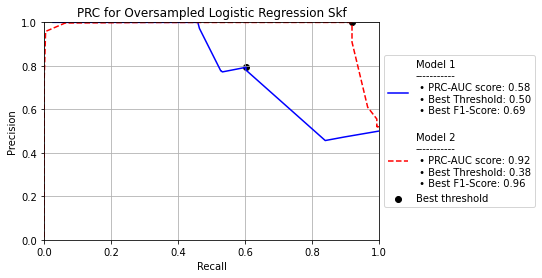

Best Threshold=0.555807, F1-Score=0.884 for model 1
Best Threshold=0.383843, F1-Score=0.958 for model 2


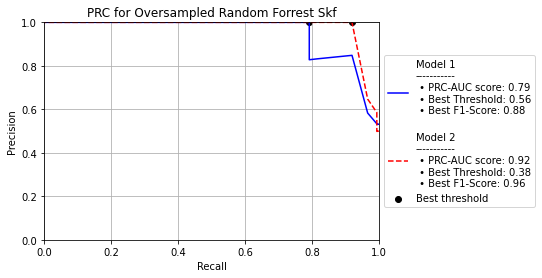

Best Threshold=0.383716, F1-Score=0.958 for model 1
Best Threshold=0.383716, F1-Score=0.958 for model 2


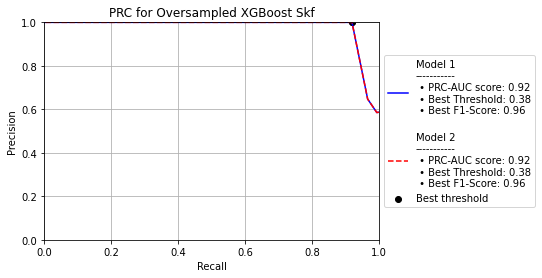

Best Threshold=0.145083, F1-Score=1.000 for model 1
Best Threshold=0.011579, F1-Score=1.000 for model 2


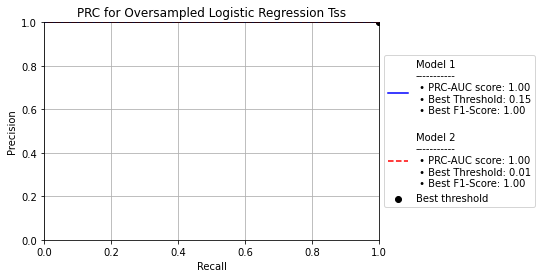

Best Threshold=0.011955, F1-Score=1.000 for model 1
Best Threshold=0.011733, F1-Score=1.000 for model 2


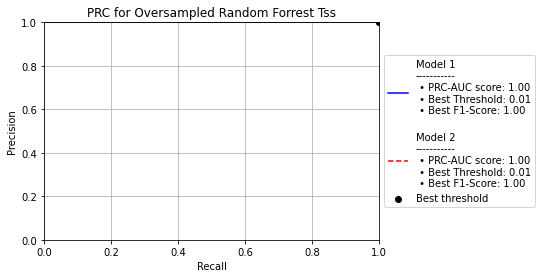

Best Threshold=0.011822, F1-Score=1.000 for model 1
Best Threshold=0.011770, F1-Score=1.000 for model 2


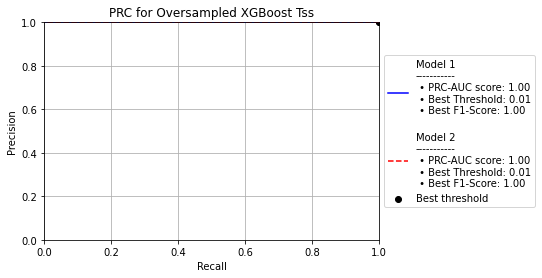

In [75]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Oversampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Oversampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Oversampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Oversampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Oversampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Oversampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Oversampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Oversampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Oversampled XGBoost Tss")

##### Combining Oversampling with Undersampling

In [76]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [77]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(56737, 5)
x2 Before SMOTE:
(56737, 129)
x1 After SMOTE:
(100906, 5)
x2 After SMOTE:
(100906, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [78]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(100906, 5)
x2 Before RandomUnderSampler:
(100906, 129)
x1 After RandomUnderSampler:
(100906, 5)
x2 After RandomUnderSampler:
(100906, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [79]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[54][0] = "OSUS_Combination_Logistic_Regression"
results_data[54][1] = lr_model1.score(x1_test, y1_test)
results_data[54][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[55][0] = "OSUS_Combination_Random_Forrest"
results_data[55][1] = rf_model1.score(x1_test, y1_test)
results_data[55][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[56][0] = "OSUS_Combination_XGB_Classifier"
results_data[56][1] = xgb_model1.score(x1_test, y1_test)
results_data[56][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5315473044397463
Logistic regression training score for model 2: 0.7075184989429175
Random Forrest Classification training score for model 1: 0.7076506342494715
Random Forrest Classification training score for model 2: 0.7076836680761099
XGB Classifier training score for model 1: 0.7076506342494715
XGB Classifier training score for model 2: 0.7076836680761099


In [80]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5156988218567231
Average Precision-Recall Score: 0.5325090106817256
PRC-AUC for model 1: 0.45829197327799276
Accuracy: 0.532
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.62      0.57     15215
           1       0.53      0.44      0.49     15057

    accuracy                           0.53     30272
   macro avg       0.53      0.53      0.53     30272
weighted avg       0.53      0.53      0.53     30272


Scores for model 2
------------------
Roc_Auc Score: 0.7549805601241298
Average Precision-Recall Score: 0.688146139165179
PRC-AUC for model 2: 0.7179808599638114
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.62      0.68     15215
           1       0.68      0.79      0.73     15057

    accuracy      

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.435149, F1-Score=0.664 for model 1
Best Threshold=0.409379, F1-Score=0.741 for model 2


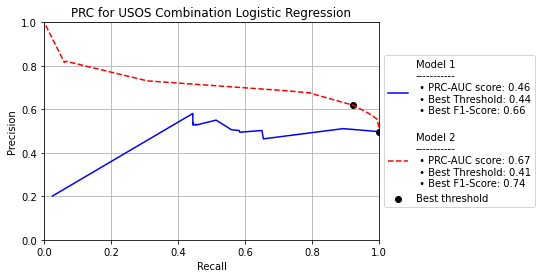

In [81]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.387106, F1-Score=0.741 for model 1
Best Threshold=0.394746, F1-Score=0.741 for model 2


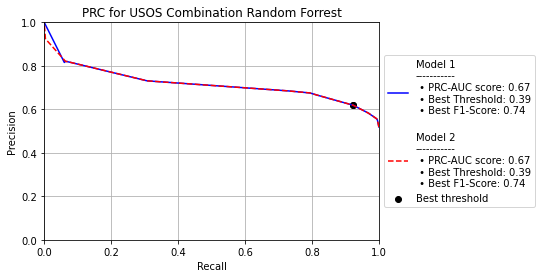

In [82]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.409641, F1-Score=0.741 for model 1
Best Threshold=0.409648, F1-Score=0.741 for model 2


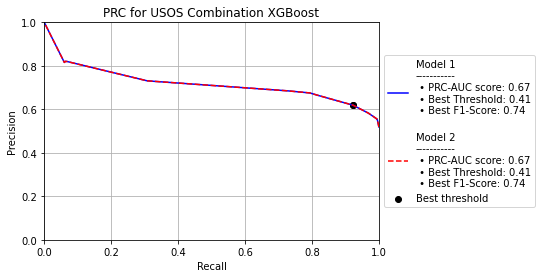

In [83]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

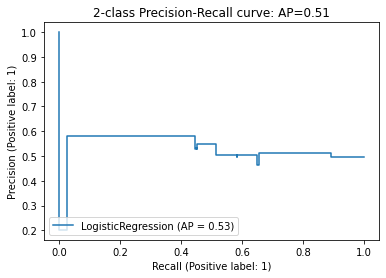

In [84]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

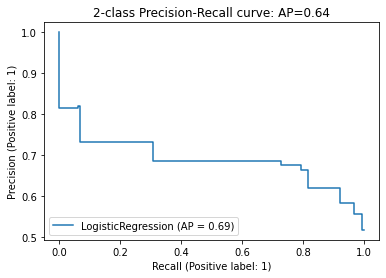

In [85]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [86]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr_model1.score(x1_test, y1_test)
results_data[57][2] = lr_model2.score(x2_test, y2_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf_model1.score(x1_test, y1_test)
results_data[58][2] = rf_model2.score(x2_test, y2_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb_model1.score(x1_test, y1_test)
results_data[59][2] = xgb_model2.score(x2_test, y2_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5156988218567231
Average Precision-Recall Score: 0.5325090106817256
PRC-AUC for model 1: 0.45829197327799276
Accuracy: 0.497
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15215
           1       0.50      1.00      0.66     15057

    accuracy                           0.50     30272
   macro avg       0.25      0.50      0.33     30272
weighted avg       0.25      0.50      0.33     30272


Scores for model 2
------------------
Roc_Auc Score: 0.7549805601241298
Average Precision-Recall Score: 0.688146139165179
PRC-AUC for model 2: 0.6727614557041167
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.44      0.58     15215
           1       0.62      0.92      0.74     15057

    accuracy                           0.68     30272
   macro avg       0.74      0.68      0.66     30272
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [87]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100902 100904 100905] | TEST: [    23     33     55 ... 100899 100900 100903]

Model Score: 0.5358240015855713
Average Precision-Recall Score: 0.526014029767608
PRC-AUC Score: 0.4694186496657685
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.63      0.57      4986
           1       0.55      0.44      0.49      5105

    accuracy                           0.54     10091
   macro avg       0.54      0.54      0.53     10091
weighted avg       0.54      0.54      0.53     10091

Accuracy: 0.536
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100902 100904 100905] | TEST: [    23     33     55 ... 100899 100900 100903]

Model Score: 0.5358240015855713
Average Precision-Recall Score: 0.526014029767608
PRC-AUC Score: 0.7348302166444224
Classification

In [88]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[64][1] = model_score
results_data[64][3] = acc
results_data[64][5] = prc_val
results_data[64][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[65][1] = model_score
results_data[65][3] = acc
results_data[65][5] = prc_val
results_data[65][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[66][1] = model_score
results_data[66][3] = acc
results_data[66][5] = prc_val
results_data[66][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[67][1] = model_score
results_data[67][3] = acc
results_data[67][5] = prc_val
results_data[67][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.711595639246779

Average Precision-Recall Score: 0.6644827624386498
PRC-AUC Score: 0.570393350792452
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      5045
           1       0.78      0.59      0.67      5045

    accuracy                           0.71     10090
   macro avg       0.72      0.71      0.71     10090
weighted avg       0.72      0.71      0.71     10090

Accuracy: 0.712
---------------------
With best threshold
TRAIN: [    0     1     2 ... 95858 95859 95860] | TEST: [ 45408  45409  45410 ... 100903 100904 100905]

Model Score: 0.711595639246779

Average Precision-Recall Score: 0.6644827624386498
PRC-AUC Score: 0.7084095618211902
Classification Report:

 

In [89]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[68][1] = model_score
results_data[68][3] = acc
results_data[68][5] = prc_val
results_data[68][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[69][1] = model_score
results_data[69][3] = acc
results_data[69][5] = prc_val
results_data[69][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[70][1] = model_score
results_data[70][3] = acc
results_data[70][5] = prc_val
results_data[70][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[71][1] = model_score
results_data[71][3] = acc
results_data[71][5] = prc_val
results_data[71][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 50452 50453 50454] | TEST: [50455 50456 50457 ... 67269 67270 67271]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0000000000000002
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16817.0

    accuracy                           0.00   16817.0
   macro avg       0.00      0.00      0.00   16817.0
weighted avg       0.00      0.00      0.00   16817.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 50452 50453 50454] | TEST: [50455 50456 50457 ... 67269 67270 67271]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [90]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.7062438057482656
Average Precision-Recall Score: 0.6465808893991488
PRC-AUC Score: 0.6745738777242335
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.62      0.67      4948
           1       0.68      0.79      0.73      5142

    accuracy                           0.71     10090
   macro avg       0.71      0.70      0.70     10090
weighted avg       0.71      0.71      0.70     10090

Accuracy: 0.706
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100902 100903 100905] | TEST: [    14     16     29 ... 100881 100882 100904]

Model Score: 0.7062438057482656
Average Precision-Recall Score: 0.6465808893991488
PRC-AUC Score: 0.6797657453239377
Classificati

In [91]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[64][2] = model_score
results_data[64][4] = acc
results_data[64][6] = prc_val
results_data[64][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[65][2] = model_score
results_data[65][4] = acc
results_data[65][6] = prc_val
results_data[65][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[66][2] = model_score
results_data[66][4] = acc
results_data[66][6] = prc_val
results_data[66][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[67][2] = model_score
results_data[67][4] = acc
results_data[67][6] = prc_val
results_data[67][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 100903 100904 100905] | TEST: [15138 15139 15140 ... 70631 70632 70633]

Model Score: 0.8953522941234764

Average Precision-Recall Score: 0.8952739843053581
PRC-AUC Score: 0.908261887061526
Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5045
           1       1.00      0.79      0.88      5046

    accuracy                           0.90     10091
   macro avg       0.91      0.90      0.89     10091
weighted avg       0.91      0.90      0.89     10091

Accuracy: 0.895
---------------------
With best threshold
TRAIN: [     0      1      2 ... 100903 100904 100905] | TEST: [15138 15139 15140 ... 70631 70632 70633]

Model Score: 0.8953522941234764

Average Precision-Recall Score: 0.8952739843053581
PRC-AUC Score: 0.8138129452464782
Classification Report:


In [92]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[68][2] = model_score
results_data[68][4] = acc
results_data[68][6] = prc_val
results_data[68][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[69][2] = model_score
results_data[69][4] = acc
results_data[69][6] = prc_val
results_data[69][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[70][2] = model_score
results_data[70][4] = acc
results_data[70][6] = prc_val
results_data[70][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[71][2] = model_score
results_data[71][4] = acc
results_data[71][6] = prc_val
results_data[71][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 50452 50453 50454] | TEST: [50455 50456 50457 ... 67269 67270 67271]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   16817.0

    accuracy                           0.00   16817.0
   macro avg       0.00      0.00      0.00   16817.0
weighted avg       0.00      0.00      0.00   16817.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [    0     1     2 ... 50452 50453 50454] | TEST: [50455 50456 50457 ... 67269 67270 67271]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00  

Best Threshold=0.433808, F1-Score=0.672 for model 1
Best Threshold=0.404248, F1-Score=0.752 for model 2


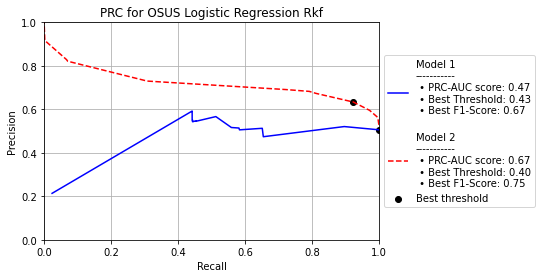

Best Threshold=0.404401, F1-Score=0.752 for model 1
Best Threshold=0.404435, F1-Score=0.752 for model 2


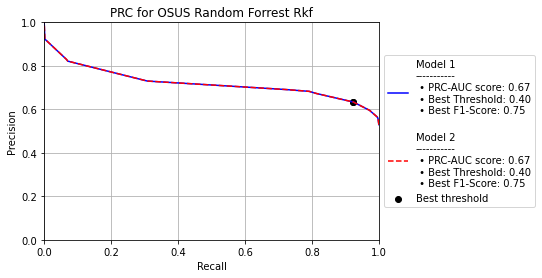

Best Threshold=0.404400, F1-Score=0.752 for model 1
Best Threshold=0.404407, F1-Score=0.752 for model 2


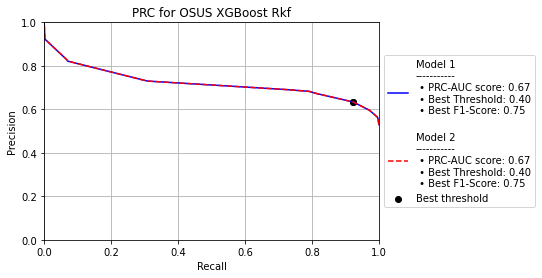

Best Threshold=0.501996, F1-Score=0.678 for model 1
Best Threshold=0.382320, F1-Score=0.916 for model 2


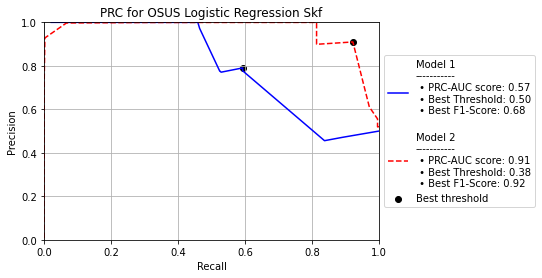

Best Threshold=0.423281, F1-Score=0.897 for model 1
Best Threshold=0.382252, F1-Score=0.960 for model 2


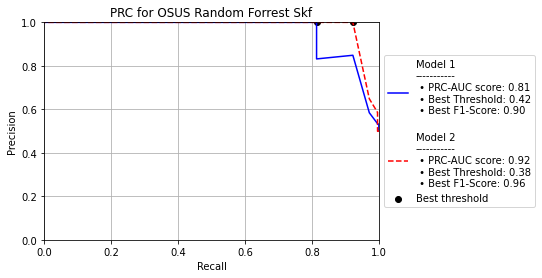

Best Threshold=0.382492, F1-Score=0.959 for model 1
Best Threshold=0.382495, F1-Score=0.960 for model 2


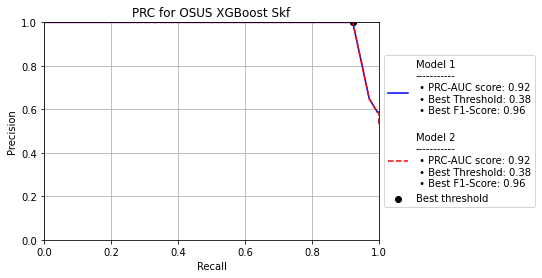

Best Threshold=0.000011, F1-Score=1.000 for model 1
Best Threshold=0.000000, F1-Score=1.000 for model 2


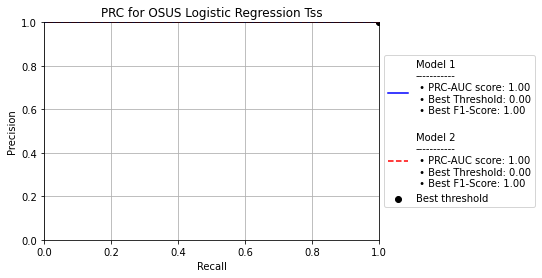

Best Threshold=0.382583, F1-Score=0.884 for model 1
Best Threshold=0.382055, F1-Score=0.960 for model 2


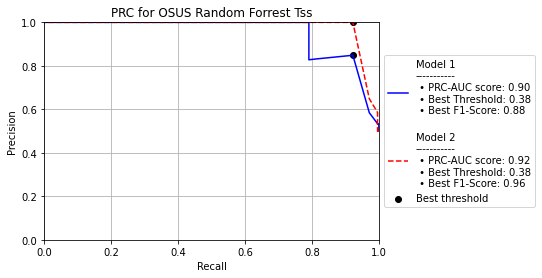

Best Threshold=0.000014, F1-Score=1.000 for model 1
Best Threshold=0.000013, F1-Score=1.000 for model 2


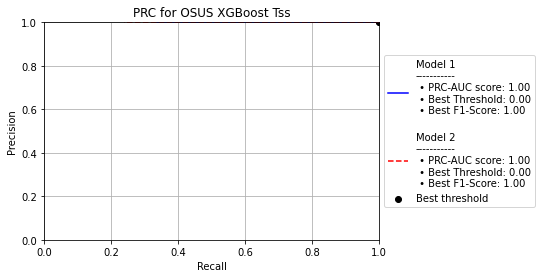

In [93]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "OSUS Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "OSUS Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "OSUS XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "OSUS Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "OSUS Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "OSUS XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "OSUS Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "OSUS Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "OSUS XGBoost Tss")

In [94]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [95]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.886500,0.886500,0.886500,0.886500,0.126740,0.228638,0.110482,0.256094
1,Original_Random_Forrest,0.886676,0.886676,0.886676,0.886676,0.230936,0.230928,0.262248,0.262238
2,Original_XGB_Classifier,0.886676,0.886676,0.886676,0.886676,0.230954,0.230951,0.262269,0.262265
3,Original_Logistic_Regression_Best_Threshold,0.886500,0.886500,0.354894,0.669134,0.126740,0.228638,0.097261,0.206250
4,Original_Random_Forrest_Best_Threshold,0.886676,0.886676,0.669487,0.669487,0.230936,0.230928,0.212323,0.212323
...,...,...,...,...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.895352,0.895451,0.895352,0.895451,0.895373,0.895472,0.922117,0.922315
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.895451,0.895451,0.895451,0.895451,0.895472,0.895472,0.901088,0.922315


In [96]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.886500,0.886500,0.126740,0.110482
1,Original_Random_Forrest,0.886676,0.886676,0.230936,0.262248
2,Original_XGB_Classifier,0.886676,0.886676,0.230954,0.262269
3,Original_Logistic_Regression_Best_Threshold,0.886500,0.354894,0.126740,0.097261
4,Original_Random_Forrest_Best_Threshold,0.886676,0.669487,0.230936,0.212323
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.895352,0.895352,0.895373,0.922117
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.895451,0.895451,0.895472,0.901088


In [97]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.886500,0.886500,0.228638,0.256094
1,Original_Random_Forrest,0.886676,0.886676,0.230928,0.262238
2,Original_XGB_Classifier,0.886676,0.886676,0.230951,0.262265
3,Original_Logistic_Regression_Best_Threshold,0.886500,0.669134,0.228638,0.206250
4,Original_Random_Forrest_Best_Threshold,0.886676,0.669487,0.230928,0.212323
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.895451,0.895451,0.895472,0.922315
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.895451,0.895451,0.895472,0.922315


In [98]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
13,Original_XGB_Classifier_skf,0.889143,0.889143,0.110857,1.000000
67,OSUS_Combination_XGB_Classifier_skf,0.895352,0.895352,0.895373,0.922117
49,Oversampled_XGB_Classifier_skf,0.896046,0.896046,0.896067,0.919738
66,OSUS_Combination_Random_Forrest_skf,0.895451,0.895451,0.895472,0.813912
48,Oversampled_Random_Forrest_skf,0.896046,0.896046,0.896067,0.792113
61,OSUS_Combination_Logistic_Regression_rkf_Best_...,0.535824,0.535824,0.526014,0.734830
43,Oversampled_Logistic_Regression_rkf_Best_Thres...,0.527849,0.527849,0.527615,0.734756
37,Oversampled_Random_Forrest,0.704083,0.704083,0.688838,0.718241
38,Oversampled_XGB_Classifier,0.704017,0.704017,0.688820,0.718221
56,OSUS_Combination_XGB_Classifier,0.707651,0.707651,0.688246,0.718111


In [99]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
12,Original_Random_Forrest_skf,0.889143,0.889143,0.110857,1.000000
13,Original_XGB_Classifier_skf,0.889143,0.889143,0.110857,1.000000
67,OSUS_Combination_XGB_Classifier_skf,0.895451,0.895451,0.895472,0.922315
66,OSUS_Combination_Random_Forrest_skf,0.895451,0.895451,0.895472,0.922315
49,Oversampled_XGB_Classifier_skf,0.896046,0.896046,0.896067,0.919738
48,Oversampled_Random_Forrest_skf,0.896046,0.896046,0.896067,0.919738
46,Oversampled_Logistic_Regression_skf,0.895848,0.895848,0.895769,0.916814
64,OSUS_Combination_Logistic_Regression_skf,0.895352,0.895352,0.895274,0.908262
47,Oversampled_Logistic_Regression_skf_Best_Thres...,0.895848,0.895848,0.895769,0.816191
65,OSUS_Combination_Logistic_Regression_skf_Best_...,0.895352,0.895352,0.895274,0.813813


In [102]:
figures = [lr_skf_os_fig, rf_skf_os_fig, xgb_skf_os_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/LOG4J2/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')

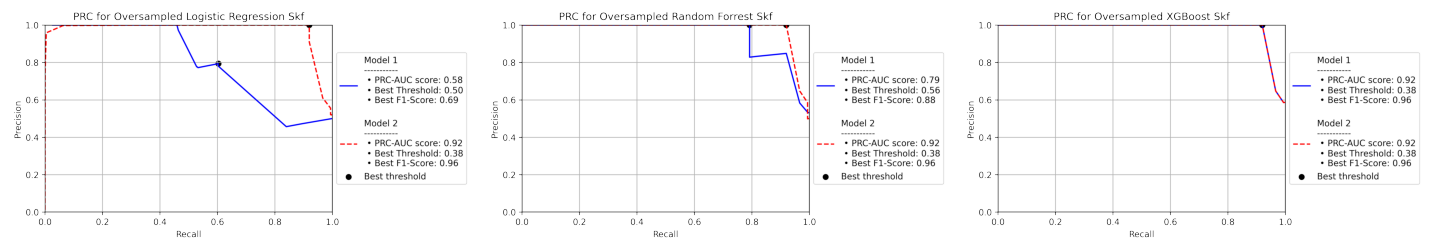

In [103]:
img_A = mpimg.imread('../../img/LOG4J2/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/LOG4J2/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/LOG4J2/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/LOG4J2/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')